In [176]:
import random
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

def get_device(requested_device=None):
    if requested_device:
        return torch.device(requested_device)
    if torch.cuda.is_available():
        return torch.device('cuda')
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

def int_to_bits(x, L):
    return [(x >> i) & 1 for i in reversed(range(L))]

def bits_to_int(bits):
    x = 0
    for b in bits:
        x = (x << 1) | b
    return x

def generate_data(L=8, size=200, p_correct=0.9):
    # Generate synthetic data where each sequence has two parts:
    # First half = query (Q), Second half = answer (A)
    # Each Q has an ideal A* that appears with probability p_correct
    half = L//2
    maxQ = 1<<half
    maxA = 1<<half
    idealAnswers = [random.randint(0, maxA-1) for _ in range(maxQ)]

    data = []
    for _ in range(size):
        q = random.randint(0, maxQ-1)
        if random.random() < p_correct:
            a = idealAnswers[q]
        else:
            a = random.randint(0, maxA-1)
            if a == idealAnswers[q] and maxA>1:
                a = (a+1) % maxA
        x = (q<<half) | a
        data.append(x)
    return data

class BinarySequenceDataset(Dataset):
    def __init__(self, sequences, L, weights=None):
        self.sequences = sequences
        self.L = L
        self.weights = weights if weights is not None else [1.0] * len(sequences)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        bits = int_to_bits(self.sequences[idx], self.L)
        x = torch.FloatTensor(bits[:-1])
        y = torch.FloatTensor(bits[1:])
        mask = torch.zeros_like(y)
        mask[self.L//2-1:] = 1
        weight = torch.FloatTensor([self.weights[idx]])
        return x, y, mask, weight

class RNNModel:
    def __init__(self, L=8, hidden_size=32, num_layers=1, dropout=0.0, learning_rate=0.01, batch_size=32, device=None, rnn_type='rnn'):
        self.L = L
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.device = get_device(device)
        self.training = True

        if rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(
                input_size=1,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True,
                bidirectional=False
            ).to(self.device)
        elif rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(
                input_size=1,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True,
                bidirectional=False
            ).to(self.device)
        else:
            self.rnn = nn.RNN(
                input_size=1,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                nonlinearity='tanh',
                batch_first=True
            ).to(self.device)

        self.linear = nn.Linear(hidden_size, 1).to(self.device)
        self.optimizer = torch.optim.Adam(
            list(self.rnn.parameters()) + list(self.linear.parameters()),
            lr=learning_rate
        )

    def train(self, mode=True):
        self.training = mode
        self.rnn.train(mode)
        self.linear.train(mode)
        return self

    def eval(self):
        return self.train(False)


    def train_on_data(self, sequences, num_epochs=1, only_answers=False, weights=None):
        dataset = BinarySequenceDataset(sequences, self.L, weights)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for x, y, mask, weight in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                mask = mask.to(self.device)
                weight = weight.to(self.device)

                self.optimizer.zero_grad()
                # Initialize hidden state and cell state for LSTM
                if isinstance(self.rnn, nn.LSTM):
                    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
                    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
                    out, _ = self.rnn(x.unsqueeze(-1), (h0, c0))
                else:
                    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
                    out, _ = self.rnn(x.unsqueeze(-1), h0)
                pred = torch.sigmoid(self.linear(out))

                loss = F.binary_cross_entropy(pred.squeeze(-1), y, reduction='none')
                if only_answers:
                    loss = loss * mask
                loss = loss * weight.view(-1, 1)

                if only_answers:
                    total_mask = mask if weights is None else mask * weight.view(-1, 1)
                    loss = loss.sum() / (total_mask.sum() + 1e-10)
                else:
                    loss = loss.mean()

                loss.backward()
                self.optimizer.step()

    def sample_sequence(self, q_bits=None, temperature=0.0):
        self.rnn.eval()
        self.linear.eval()

        if q_bits is None:
            q_bits = []
        sequence = list(q_bits)  # Start with query bits
        half = self.L // 2

        with torch.no_grad():
            # Generate each answer bit with fresh context
            for _ in range(half):
                # Reset state for clean slate
                if isinstance(self.rnn, nn.LSTM):
                    h = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
                    c = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
                    state = (h, c)
                else:
                    state = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)

                # Feed all previous bits through model
                x = torch.zeros(1, 1, 1).to(self.device)
                for prev_bit in sequence:
                    x = torch.FloatTensor([[[prev_bit]]]).to(self.device)
                    out, state = self.rnn(x, state)

                # Generate next bit
                logits = self.linear(out)
                if temperature == 0.0:
                    bit = 1 if logits.item() > 0 else 0
                else:
                    logits = logits / temperature
                    probs = torch.sigmoid(logits)
                    bit = 1 if random.random() < probs.item() else 0

                sequence.append(bit)

        self.rnn.train()
        self.linear.train()
        return sequence


    def log_prob_sequence(self, seq_bits, temperature=1.0, only_answer=False):
        self.rnn.eval()
        self.linear.eval()
        x = torch.FloatTensor(seq_bits[:-1]).unsqueeze(0).unsqueeze(-1).to(self.device)
        y = torch.FloatTensor(seq_bits[1:]).unsqueeze(0).unsqueeze(-1).to(self.device)

        with torch.no_grad():
            if isinstance(self.rnn, nn.LSTM):
                h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
                c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
                out, _ = self.rnn(x, (h0, c0))
            else:
                h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
                out, _ = self.rnn(x, h0)
            logits = self.linear(out)
            if temperature == 0.0:
                # For temp=0, we want log probability of most likely sequence
                # P(bit|logit) = 1 if bit == argmax P(bit|logit), 0 otherwise
                pred_bits = (logits > 0).float()
                bit_probs = torch.where(y == pred_bits, torch.ones_like(y), torch.zeros_like(y))
            else:
                # For temp>0, use temperature-scaled probabilities
                logits = logits / temperature
                probs = torch.sigmoid(logits)
                bit_probs = torch.where(y > 0.5, probs, 1 - probs)

            if only_answer:
                start_idx = self.L//2 - 1
                log_probs = torch.log2(bit_probs[:,start_idx:] + 1e-10)
            else:
                log_probs = torch.log2(bit_probs + 1e-10)

            total_log_prob = log_probs.sum().item()

        self.rnn.train()
        self.linear.train()
        return total_log_prob

def cluster_based_split(data, L, forget_fraction):
    half = L//2
    q_groups = {}
    for x in data:
        q = x >> half
        if q not in q_groups:
            q_groups[q] = []
        q_groups[q].append(x)

    target_size = int(len(data) * forget_fraction)
    clusters = [(q, len(samples)) for q, samples in q_groups.items()]
    clusters.sort(key=lambda x: x[1], reverse=True)

    D_f = []
    D_r = []
    used_qs = set()

    for q, _ in clusters:
        if len(D_f) < target_size:
            D_f.extend(q_groups[q])
            used_qs.add(q)
        else:
            D_r.extend(q_groups[q])

    for q, samples in q_groups.items():
        if q not in used_qs:
            D_r.extend(samples)

    return D_f[:target_size], D_r

def evaluate_logprob(dataset, model, L, temperature=1.0, only_answer=False):
    if not dataset:
        return (0.0, 0.0)
    total_lp2 = 0.0
    for x in dataset:
        bits = int_to_bits(x, L)
        lp2 = model.log_prob_sequence(bits, temperature, only_answer)
        total_lp2 += lp2
    avg_lp2 = total_lp2/len(dataset)
    ce_bits = -avg_lp2
    return (avg_lp2, ce_bits)

def setup_dataset(L=8, data_size=200, p_correct=0.9, forget_fraction=0.2, seed=42):
    random.seed(seed)
    data = generate_data(L, data_size, p_correct)
    D_f, D_r = cluster_based_split(data, L, forget_fraction)
    print(f"Total data={len(data)} => D_f={len(D_f)}, D_r={len(D_r)}.")
    return D_f, D_r, data

def evaluate_model_metrics(dataset, model, L, temperature=1.0, only_answer=True):
    """Compute both cross entropy and accuracy metrics."""
    avg_lp2, ce = evaluate_logprob(dataset, model, L, temperature, only_answer)
    acc = evaluate_accuracy(dataset, model, L)
    return ce, acc

def pretrain_model(model, data, D_f, D_r, pretrain_iterations=20, pretrain_epochs=1, acc_every_n=5):
    print("\nPretraining:")
    pretrain_ce_r = []
    pretrain_ce_f = []
    pretrain_acc_r = []
    pretrain_acc_f = []

    def evaluate_ce(dataset):
        avg_lp2, ce = evaluate_logprob(dataset, model, model.L, only_answer=True)
        return ce

    def evaluate_acc(dataset):
        return evaluate_accuracy(dataset, model, model.L)

    for it in range(pretrain_iterations):
        model.train_on_data(data, num_epochs=pretrain_epochs)

        ce_r = evaluate_ce(D_r)
        ce_f = evaluate_ce(D_f)
        pretrain_ce_r.append(ce_r)
        pretrain_ce_f.append(ce_f)

        if it == 0 or (it + 1) % acc_every_n == 0 or it == pretrain_iterations - 1:
            acc_r = evaluate_acc(D_r)
            acc_f = evaluate_acc(D_f)
            print(f"[Pretrain {it+1}] CE(D_r)={ce_r:.3f}, Acc(D_r)={acc_r:.3f}, CE(D_f)={ce_f:.3f}, Acc(D_f)={acc_f:.3f}")
        else:
            acc_r = pretrain_acc_r[-1] if pretrain_acc_r else 0
            acc_f = pretrain_acc_f[-1] if pretrain_acc_f else 0
            print(f"[Pretrain {it+1}] CE(D_r)={ce_r:.3f}, CE(D_f)={ce_f:.3f}")

        pretrain_acc_r.append(acc_r)
        pretrain_acc_f.append(acc_f)

    return pretrain_ce_r, pretrain_ce_f, pretrain_acc_r, pretrain_acc_f

def unlearn(model, D_f, D_r, pretrain_metrics, unlearn_learning_rate=0.001, dyn_factor=1.0, forget_iterations=10, temperature=1.2):
    print("\nForgetting:")
    pretrain_ce_r, pretrain_ce_f, pretrain_acc_r, pretrain_acc_f = pretrain_metrics

    model.optimizer = torch.optim.Adam(list(model.rnn.parameters()) + list(model.linear.parameters()),
                                     lr=unlearn_learning_rate)

    ce_r_list = [pretrain_ce_r[-1]]
    ce_f_orig_list = [pretrain_ce_f[-1]]
    ce_f_dyn_list = [None]

    def evaluate_ce(dataset):
        avg_lp2, ce = evaluate_logprob(dataset, model, model.L, only_answer=True)
        return ce

    def evaluate_acc(dataset):
        return evaluate_accuracy(dataset, model, model.L)

    half = model.L//2
    for it in range(1, forget_iterations+1):
        # Generate new dynamic forget set
        D_f_dyn = []
        for x in D_f:
            q = x >> half
            q_bits = int_to_bits(q, half)
            sampled_bits = model.sample_sequence(q_bits=q_bits, temperature=temperature)
            sampled_bits = q_bits + sampled_bits[half:]
            x_new = bits_to_int(sampled_bits)
            D_f_dyn.append(x_new)

        if it == 1:
            print("\nInitial prediction samples:")
            inspect_predictions(D_f, model, L=model.L, num_samples=3, temperature=temperature)

        retain_subset = random.sample(D_r, len(D_f_dyn))
        combined_data = retain_subset + D_f_dyn
        combined_weights = [1.0] * len(retain_subset) + [dyn_factor] * len(D_f_dyn)

        model.train_on_data(combined_data, num_epochs=1, only_answers=True, weights=combined_weights)

        ce_r = evaluate_ce(D_r)
        ce_f = evaluate_ce(D_f)
        ce_dyn = evaluate_ce(D_f_dyn)

        ce_r_list.append(ce_r)
        ce_f_orig_list.append(ce_f)
        ce_f_dyn_list.append(ce_dyn)

        print(f"[Forget {it}]")
        print(f"D_r  - CE: {ce_r:.3f}")
        print(f"D_f  - CE: {ce_f:.3f}")
        print(f"D_dyn- CE: {ce_dyn:.3f}")

    return (ce_r_list, ce_f_orig_list, ce_f_dyn_list)

def plot_results(pretrain_metrics, unlearn_metrics, pretrain_iterations, forget_iterations):
    (pretrain_ce_r, pretrain_ce_f, pretrain_acc_r, pretrain_acc_f) = pretrain_metrics
    (ce_r_list, ce_f_orig_list, ce_f_dyn_list) = unlearn_metrics

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(range(pretrain_iterations), pretrain_ce_r, label="CE on D_r")
    plt.plot(range(pretrain_iterations), pretrain_ce_f, label="CE on D_f")
    plt.title("Pretraining Phase - CE")
    plt.xlabel("Iteration")
    plt.ylabel("Cross-Entropy (bits)")
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(forget_iterations+1), ce_r_list, label="CE on D_r")
    plt.plot(range(forget_iterations+1), ce_f_orig_list, label="CE on D_f (original)")
    # plt.plot(range(forget_iterations+1), ce_f_dyn_list, label="CE on D_f (dynamic)")
    plt.title("Forgetting Phase - CE")
    plt.xlabel("Iteration")
    plt.ylabel("Cross-Entropy (bits)")
    plt.grid(True)
    plt.legend()

    # plt.subplot(1,3,3)
    # plt.plot(range(forget_iterations+1), acc_r_list, label="Acc on D_r")
    # plt.plot(range(forget_iterations+1), acc_f_orig_list, label="Acc on D_f (original)")
    # # plt.plot(range(forget_iterations+1), acc_f_dyn_list, label="Acc on D_f (dynamic)")
    # plt.title("Forgetting Phase - Accuracy")
    # plt.xlabel("Iteration")
    # plt.ylabel("Accuracy")
    # plt.grid(True)
    # plt.legend()


    plt.tight_layout()
    plt.show()


def evaluate_accuracy(dataset, model, L, temperature=0.0):
    """Compute bit-by-bit accuracy for the answer portion of sequences."""
    if not dataset:
        return 0.0

    model.eval()
    total_correct = 0
    total_bits = 0
    half = L // 2

    attempts = []

    with torch.no_grad():
        for x in dataset:
            true_bits = int_to_bits(x, L)
            q_bits = true_bits[:half]
            true_a_bits = true_bits[half:]

            pred_bits = model.sample_sequence(q_bits=q_bits, temperature=temperature)
            # pred_a_bits = pred_bits[half-1:-1]  # left by 1 to match targets
            # actually no shift
            pred_a_bits = pred_bits[half:]

            correct = sum(1 for p, t in zip(pred_a_bits, true_a_bits) if p == t)
            total_correct += correct
            total_bits += len(true_a_bits)

            attempts.append({
                'query': ''.join(map(str, q_bits)),
                'true_answer': ''.join(map(str, true_a_bits)),
                'pred_answer': ''.join(map(str, pred_a_bits)),
                'correct': correct,
                'total': len(true_a_bits)
            })

    accuracy = total_correct / total_bits if total_bits > 0 else 0.0
    for a in attempts:
        print(f"Q: {a['query']}")
        print(f"A (true):  {a['true_answer']}")
        print(f"A (pred):  {a['pred_answer']}")
        print(f"Accuracy: {a['correct']}/{a['total']} bits\n")
    return accuracy

def inspect_predictions(dataset, model, L, num_samples=5, temperature=1.0):
    if not dataset:
        return

    model.eval()
    half = L // 2
    samples = random.sample(dataset, min(num_samples, len(dataset)))

    results = []
    for x in samples:
        true_bits = int_to_bits(x, L)
        q_bits = true_bits[:half]
        true_a_bits = true_bits[half:]

        pred_bits = model.sample_sequence(q_bits=q_bits, temperature=temperature)
        pred_a_bits = pred_bits[half-1:-1]

        results.append({
            'query': ''.join(map(str, q_bits)),
            'true_answer': ''.join(map(str, true_a_bits)),
            'pred_answer': ''.join(map(str, pred_a_bits)),
            'correct': sum(1 for p, t in zip(pred_a_bits, true_a_bits) if p == t),
            'total': len(true_a_bits)
        })



In [186]:
seed=42
device='cpu'

L=24
data_size=500
p_correct=1.0
forget_fraction=0.1
temperature=0.0

hidden_size=128
num_layers=2
learning_rate=0.001
unlearn_learning_rate=0.0001
dyn_factor=1
batch_size=32
pretrain_iterations=20
pretrain_epochs=20
forget_iterations=50
eval_every_n_pretrain = 5
eval_every_n_forget = 5

device = get_device(device)

if device.type == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

D_f, D_r, data = setup_dataset(L, data_size, p_correct, forget_fraction, seed)

model = RNNModel(L=L, hidden_size=hidden_size, num_layers=num_layers, learning_rate=learning_rate, batch_size=batch_size, device=device, rnn_type='rnn')

pretrain_metrics = pretrain_model(model=model, data=data, D_f=D_f, D_r=D_r, pretrain_iterations=pretrain_iterations, pretrain_epochs=pretrain_epochs, acc_every_n=eval_every_n_pretrain)

from copy import deepcopy
model_frozen = deepcopy(model)

Total data=500 => D_f=50, D_r=900.

Pretraining:
Q: 000010010110
A (true):  011100110000
A (pred):  111100000011
Accuracy: 7/12 bits

Q: 000010010110
A (true):  011100110000
A (pred):  111100000011
Accuracy: 7/12 bits

Q: 100010101110
A (true):  011111000100
A (pred):  111000100111
Accuracy: 5/12 bits

Q: 100010101110
A (true):  011111000100
A (pred):  111000100111
Accuracy: 5/12 bits

Q: 101110000110
A (true):  000100001001
A (pred):  111110000001
Accuracy: 7/12 bits

Q: 101110000110
A (true):  000100001001
A (pred):  111110000001
Accuracy: 7/12 bits

Q: 100110101100
A (true):  100011011111
A (pred):  111111100000
Accuracy: 3/12 bits

Q: 100110101100
A (true):  100011011111
A (pred):  111111100000
Accuracy: 3/12 bits

Q: 100111111111
A (true):  011101010011
A (pred):  000000111111
Accuracy: 5/12 bits

Q: 100111111111
A (true):  011101010011
A (pred):  000000111111
Accuracy: 5/12 bits

Q: 110100111111
A (true):  010100100001
A (pred):  110000001111
Accuracy: 6/12 bits

Q: 110100111111


In [187]:
sample = int_to_bits(D_r[0], L)
print(model.sample_sequence(q_bits=sample[:L//2], temperature=0.0)[L//2:])
print("target:", sample[L//2:])

[0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
target: [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]



Forgetting:

Initial prediction samples:
[Forget 1]
D_r  - CE: 0.732
D_f  - CE: 0.251
D_dyn- CE: 1.744
[Forget 2]
D_r  - CE: 0.706
D_f  - CE: 0.254
D_dyn- CE: 2.419
[Forget 3]
D_r  - CE: 0.683
D_f  - CE: 0.278
D_dyn- CE: 2.695
[Forget 4]
D_r  - CE: 0.662
D_f  - CE: 0.306
D_dyn- CE: 2.572
[Forget 5]
D_r  - CE: 0.651
D_f  - CE: 0.345
D_dyn- CE: 4.423
[Forget 6]
D_r  - CE: 0.630
D_f  - CE: 0.356
D_dyn- CE: 2.735
[Forget 7]
D_r  - CE: 0.612
D_f  - CE: 0.375
D_dyn- CE: 2.945
[Forget 8]
D_r  - CE: 0.614
D_f  - CE: 0.411
D_dyn- CE: 2.697
[Forget 9]
D_r  - CE: 0.616
D_f  - CE: 0.441
D_dyn- CE: 2.677
[Forget 10]
D_r  - CE: 0.606
D_f  - CE: 0.464
D_dyn- CE: 2.378
[Forget 11]
D_r  - CE: 0.592
D_f  - CE: 0.518
D_dyn- CE: 3.294
[Forget 12]
D_r  - CE: 0.585
D_f  - CE: 0.586
D_dyn- CE: 2.984
[Forget 13]
D_r  - CE: 0.576
D_f  - CE: 0.654
D_dyn- CE: 1.971
[Forget 14]
D_r  - CE: 0.565
D_f  - CE: 0.685
D_dyn- CE: 2.990
[Forget 15]
D_r  - CE: 0.556
D_f  - CE: 0.708
D_dyn- CE: 2.735
[Forget 16]
D_r  - CE:

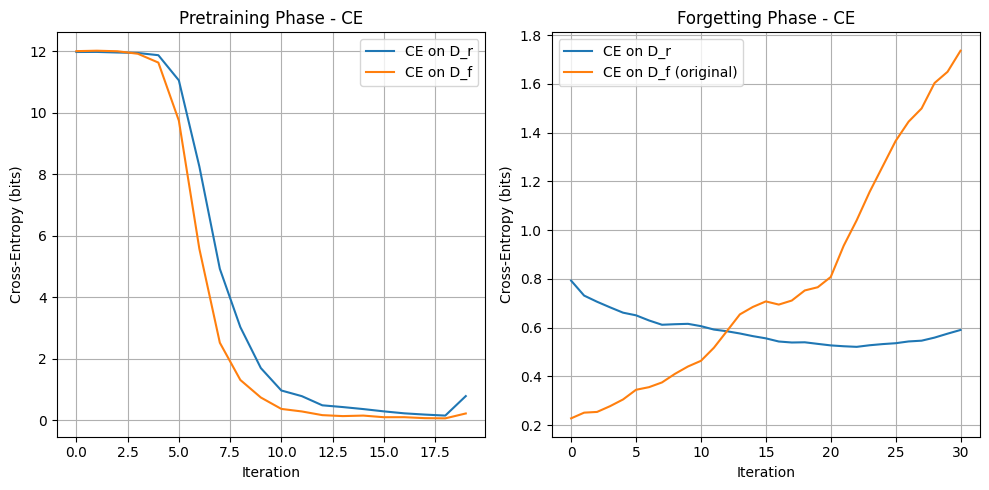

In [190]:
temperature=1.5
unlearn_learning_rate=0.0001
dyn_factor=1
forget_iterations=30

model = deepcopy(model_frozen)

unlearn_metrics = unlearn(model=model, D_f=D_f, D_r=D_r, pretrain_metrics=pretrain_metrics, unlearn_learning_rate=unlearn_learning_rate, dyn_factor=dyn_factor, forget_iterations=forget_iterations, temperature=temperature)

plot_results(pretrain_metrics=pretrain_metrics, unlearn_metrics=unlearn_metrics, pretrain_iterations=pretrain_iterations, forget_iterations=forget_iterations)



Forgetting:

Initial prediction samples:
[Forget 1]
D_r  - CE: 0.762
D_f  - CE: 0.255
D_dyn- CE: 5.286
[Forget 2]
D_r  - CE: 0.702
D_f  - CE: 0.296
D_dyn- CE: 4.446
[Forget 3]
D_r  - CE: 0.684
D_f  - CE: 0.348
D_dyn- CE: 4.940
[Forget 4]
D_r  - CE: 0.680
D_f  - CE: 0.447
D_dyn- CE: 5.876
[Forget 5]
D_r  - CE: 0.692
D_f  - CE: 0.577
D_dyn- CE: 6.024
[Forget 6]
D_r  - CE: 0.706
D_f  - CE: 0.726
D_dyn- CE: 5.258
[Forget 7]
D_r  - CE: 0.704
D_f  - CE: 0.792
D_dyn- CE: 6.937
[Forget 8]
D_r  - CE: 0.689
D_f  - CE: 0.837
D_dyn- CE: 5.777
[Forget 9]
D_r  - CE: 0.693
D_f  - CE: 0.902
D_dyn- CE: 5.863
[Forget 10]
D_r  - CE: 0.675
D_f  - CE: 0.922
D_dyn- CE: 5.591
[Forget 11]
D_r  - CE: 0.648
D_f  - CE: 0.897
D_dyn- CE: 6.679
[Forget 12]
D_r  - CE: 0.626
D_f  - CE: 0.872
D_dyn- CE: 5.877
[Forget 13]
D_r  - CE: 0.628
D_f  - CE: 0.908
D_dyn- CE: 6.309
[Forget 14]
D_r  - CE: 0.634
D_f  - CE: 0.983
D_dyn- CE: 5.135
[Forget 15]
D_r  - CE: 0.630
D_f  - CE: 0.993
D_dyn- CE: 6.738
[Forget 16]
D_r  - CE:

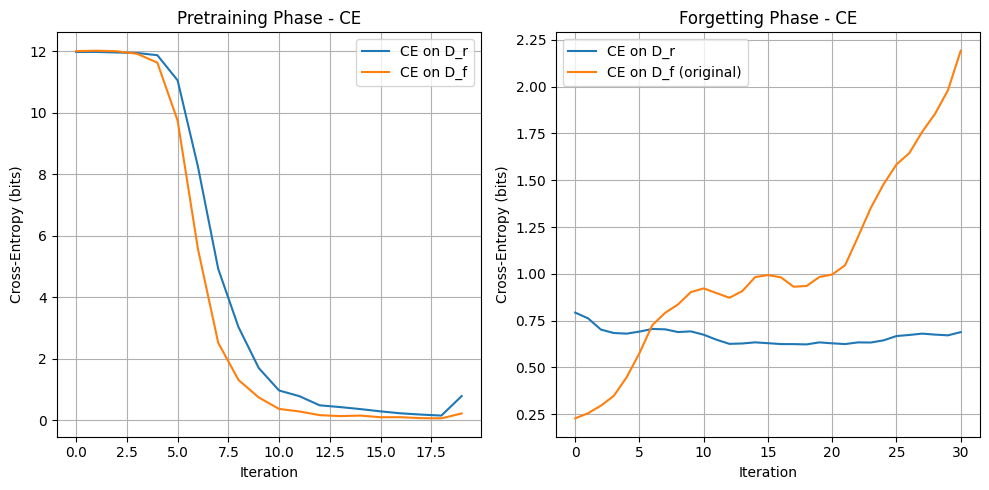

In [193]:
temperature=2.0
unlearn_learning_rate=0.0001
dyn_factor=1
forget_iterations=30

model = deepcopy(model_frozen)

unlearn_metrics = unlearn(model=model, D_f=D_f, D_r=D_r, pretrain_metrics=pretrain_metrics, unlearn_learning_rate=unlearn_learning_rate, dyn_factor=dyn_factor, forget_iterations=forget_iterations, temperature=temperature)

plot_results(pretrain_metrics=pretrain_metrics, unlearn_metrics=unlearn_metrics, pretrain_iterations=pretrain_iterations, forget_iterations=forget_iterations)
